In [14]:
# Goal: Investigate what Mni we would get with the pure arnett-rule
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from scipy.optimize import curve_fit, root_scalar
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.late_nickel as lateni

In [11]:
num_pregen = 6000
num_times = 15
bolometric_method = 'lyman'

def estimate_mni(ds, texpl_range):
    t_min = ds.transient.prior_t0 - 5
    t_max = ds.transient.prior_t0 + 5
    
    time_valid=np.array([[1, 1e12]])
    texpl_min, texpl_max = texpl_range
    
    pregen_t = np.empty((num_pregen, num_times), dtype=np.float)
    pregen_lums = np.empty((num_pregen, num_times), dtype=np.float)
    for i in tqdm.trange(num_pregen):
        #t_grid = np.sort(np.random.uniform(t_min, t_max, M))
        t_grid = tigerfit.gen_times(num_times, time_valid, t_min, t_max)
        lc = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
        lums = np.log(utils.convert_luminosity(lc))
        #lums = utils.convert_luminosity(lc)/1e42
        pregen_lums[i] = lums
        pregen_t[i] = t_grid
    
    def prior(u):
        x = np.empty_like(u)
        # Mni
        x[0] = u[0] + 0.01
        # t_rise
        x[1] = 30*u[1]+3
        
        return x
    
    def likelihood(x):
        mni, t_rise, t_width = x
        texpl_mjd = np.random.uniform(texpl_min, texpl_max)
        
        # select random entry from pre-generated LCs
        idx = np.random.randint(0, pregen_t.shape[0])
        t_grid = pregen_t[idx]
        t_expl = t_grid - texpl_mjd
        lums = pregen_lums[idx]
        
        model = lateni.gamma_deposition(t_grid, mni) + lateni.positron_deposition(t_grid, mni)
        log_model = np.log(model)
        return -0.5 * np.sum((log_model-lums)**2)
    
    ndim = 2
    sampler = dynesty.DynamicNestedSampler(likelihood, prior, ndim, method='unif', nlive_init=2000)
    sampler.run_nested()
    dyplot.cornerplot(sampler.results, labels=['Mni'], show_titles=True)


In [13]:
#estimate_mni(dataset.load_dataset('SN2019odp_phot'), texpl_range = (58712.48, 58716.38))

In [33]:
samples = 1000
def estimate_mni2(ds, texpl_range):
    texpl_min, texpl_max = texpl_range
    texpl_mjd = np.random.uniform(texpl_min, texpl_max, samples)
    
    mni_samples = np.empty(samples)
    for i in range(samples):
        peak_mag = ds.sample_abs_lc(method=bolometric_method, t_grid=ds.transient.prior_t0, tweaks=['correlated-error'])[0]
        peak_lum = utils.convert_luminosity(peak_mag)
        tpeak = ds.transient.prior_t0 - texpl_mjd[i]
        def func(mni):
            if mni < 0.01:
                return 100*mni**2
            return lateni.gamma_deposition(tpeak, mni) + lateni.positron_deposition(tpeak, mni) - peak_lum
        sol = root_scalar(func, x0=0.05, x1=0.1)
        mni_samples[i] = sol.root
    #print(mni_samples)
    seaborn.displot(mni_samples)
    print(np.percentile(mni_samples, [32, 50, 68]))

/usr/lib/python3/dist-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


[0.2096304  0.23262525 0.25719156]


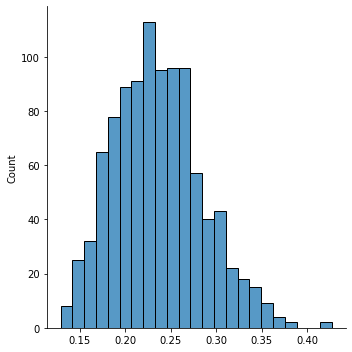

In [34]:
estimate_mni2(dataset.load_dataset('SN2019odp_phot'), texpl_range = (58712.48, 58716.38))

In [39]:
samples = 1000
def estimate_mni3(ds, texpl_range):
    texpl_min, texpl_max = texpl_range
    texpl_mjd = np.random.uniform(texpl_min, texpl_max, samples)
    
    mni_samples = np.empty(samples)
    t0_samples = np.empty(samples)
    t_grid = np.sort(np.random.uniform(ds.transient.prior_t0-5, ds.transient.prior_t0+5, 8))
    for i in range(samples):
        mags = ds.sample_abs_lc(method=bolometric_method, t_grid=t_grid, tweaks=['correlated-error'])
        def func1(t, tmax, peak, amplitude, width):
            return peak + amplitude*((t-tmax)/width)**2
        bound = [(-3, -20, 0.001, 1), (3, -15, 1, 100)]
        p, pconv = curve_fit(func1, t_grid-ds.transient.prior_t0, mags, bounds=bound)
        #print(p)
        dt_t0 = p[0]
        t0_samples[i] = dt_t0
        
        peak_mag = ds.sample_abs_lc(method=bolometric_method, t_grid=ds.transient.prior_t0+dt_t0, tweaks=['correlated-error'])[0]
        peak_lum = utils.convert_luminosity(peak_mag)
        tpeak = ds.transient.prior_t0 - texpl_mjd[i]
        def func(mni):
            if mni < 0.01:
                return 100*mni**2
            return lateni.gamma_deposition(tpeak, mni) + lateni.positron_deposition(tpeak, mni) - peak_lum
        sol = root_scalar(func, x0=0.05, x1=0.1)
        mni_samples[i] = sol.root
    #print(mni_samples)
    seaborn.displot(mni_samples)
    print(np.percentile(mni_samples, [32, 50, 68]))
    print(np.mean(t0_samples))

/usr/lib/python3/dist-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


[0.21495332 0.2346013  0.25554917]
1.3312986174078514


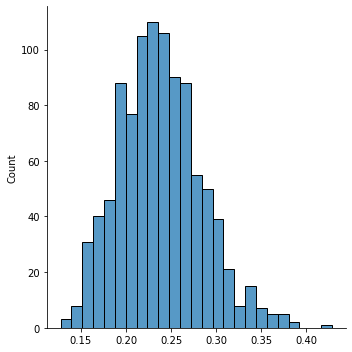

In [40]:
estimate_mni3(dataset.load_dataset('SN2019odp_phot'), texpl_range = (58712.48, 58716.38))